# data import

In [257]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math as math
import scikitplot as skplt
import bokeh
import matplotlib.patches as patches
from ipywidgets import interact, interactive, fixed, interact_manual

sns.set(style="white", palette="pastel",font_scale=1.5, rc={"lines.linewidth": 2.5,'figure.figsize':(11.7,8.27)})
pd.options.display.max_columns = None

In [259]:
mpl.rcParams['axes.linewidth'] = 2.5
mpl.rcParams['axes.edgecolor'] = "grey"
mpl.rcParams['figure.edgecolor'] = "grey"
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['legend.edgecolor'] = "grey"
mpl.rcParams['legend.shadow'] = False
mpl.rcParams['legend.facecolor'] = "white"

In [260]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

## combined test data

In [261]:
df_combined = pd.read_csv("data/exported/df_combined.csv", index_col = 0)
df_not_combined = pd.read_csv("data/exported/df_not_combined.csv", index_col = 0)
df_yeast_not_combined = pd.read_csv("data/exported/df_yeast_not_combined.csv", index_col = 0)
df_yeast_combined = pd.read_csv("data/exported/df_yeast_combined.csv", index_col = 0)

In [262]:
df_not_combined = df_not_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category"})
df_not_combined = df_not_combined.astype({"ref_number":"object"})

In [263]:
df_combined = df_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category",
                                  "modified_status_rolling_max":"object"})
df_combined = df_combined.astype({"ref_number":"object"})

In [264]:
df_yeast_not_combined = df_yeast_not_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category"})
df_yeast_not_combined = df_yeast_not_combined.astype({"ref_number":"object"})

In [265]:
df_yeast_combined = df_yeast_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category"})
df_yeast_combined = df_yeast_combined.astype({"ref_number":"object"})

In [266]:
df_combined["modified"] = df_combined.modified_status.astype(int) + df_combined.modified_status_rolling_max
label_dict = {2.0:"Modified",1.0:"Modified Neighbour",0.0:"Unmodified"}
label_enc = [label_dict[elm] for elm in df_combined.modified.values]
df_combined["modified"] = label_enc

## yeast data

In [267]:

df_yeast_combined_predicted = pd.read_csv("data/exported/df_yeast_combined_predicted.csv", index_col = 0)
df_yeast_combined_predicted.rename(columns = {"dwell_time":"dwell_time_median", "median_value":"median_value_median"}, inplace=True)

# limitation preprocessor combined

In [268]:
imputer1_combined = SimpleImputer(strategy="median")
scaler1_combined = StandardScaler()
numeric_transformer_combined = make_pipeline(imputer1_combined,scaler1_combined)


imputer2_combined = SimpleImputer(strategy='constant', fill_value='missing')
encoder_combined = OneHotEncoder(handle_unknown='error')
cat_transformer_combined = make_pipeline(imputer2_combined,encoder_combined)

In [269]:
numeric_features_combined_limited = ["dwell_time_median","dwell_time_rolling_min","dwell_time_diff_to_median"]

#preprocessing pipeline to scale numeric and onehot encode categorical values


preprocessor_combined_limited = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_combined, numeric_features_combined_limited)
    ])

# umap

In [212]:
import umap
umap = umap.UMAP()

In [213]:
embedding = umap.fit_transform(preprocessor_combined_limited.fit_transform(df_combined))

umap_df = pd.DataFrame(embedding)
umap_df["modified"] = df_combined.modified.astype("category")
umap_df.columns = ["umap_dim_1","umap_dim_2","modified_status"]

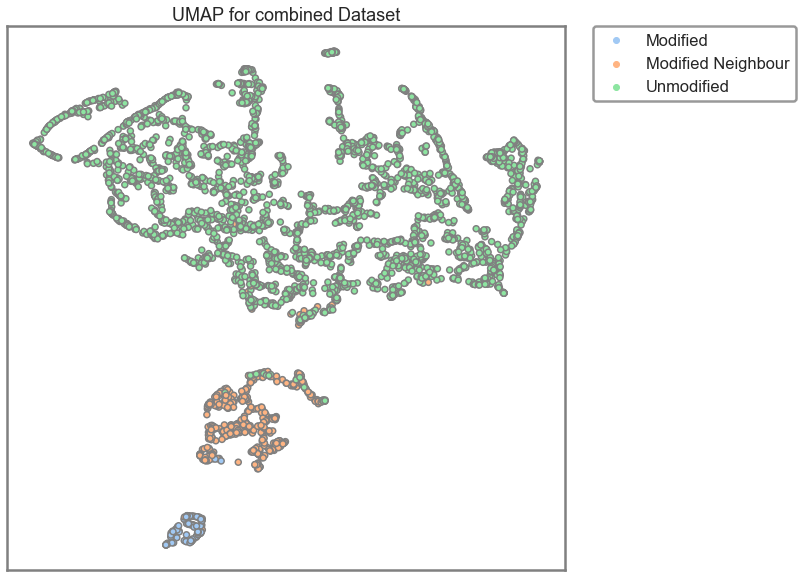

In [345]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="umap_dim_2", y="umap_dim_1", data = umap_df, hue="modified_status", edgecolor="grey", linewidth = 1.5)

plt.title("UMAP for combined Dataset")
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
h,l = ax.get_legend_handles_labels()
legend = plt.legend(h[1:],l[1:],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True)
frame = legend.get_frame()
frame.set_linewidth(2.5)

plt.yticks([])
plt.savefig("figures/umap.png",dpi=300,bbox_inches="tight" );

# TSNE

In [287]:
from sklearn.manifold import TSNE

In [288]:
tsne = TSNE(random_state=7, perplexity = 50)
tsne_combined = tsne.fit_transform(preprocessor_combined_limited.fit_transform(df_combined))
df_combined_w_tsne = pd.concat([df_combined.modified,pd.Series(tsne_combined[:,0]).rename("tsne_d1"),
                  pd.Series(tsne_combined[:,1]).rename("tsne_d2")],axis=1, )

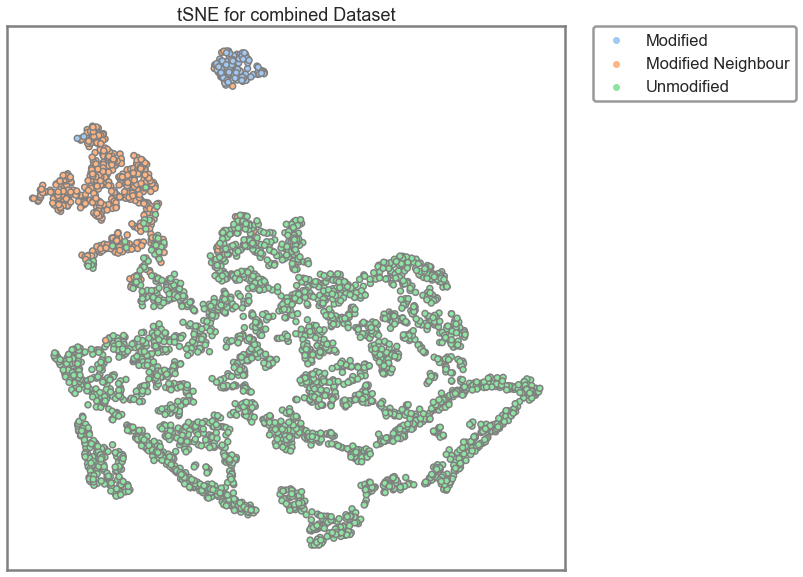

In [346]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(data = df_combined_w_tsne, x = "tsne_d1", y = "tsne_d2", hue = "modified", edgecolor="grey", linewidth = 1.5)
h,l = ax.get_legend_handles_labels()
legend = plt.legend(h[1:],l[1:],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True)
frame = legend.get_frame()
frame.set_linewidth(2.5)

plt.title("tSNE for combined Dataset")
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.savefig("figures/tsne.png",dpi=300,bbox_inches="tight" );
    

# dwell time rolling min to dwell time median

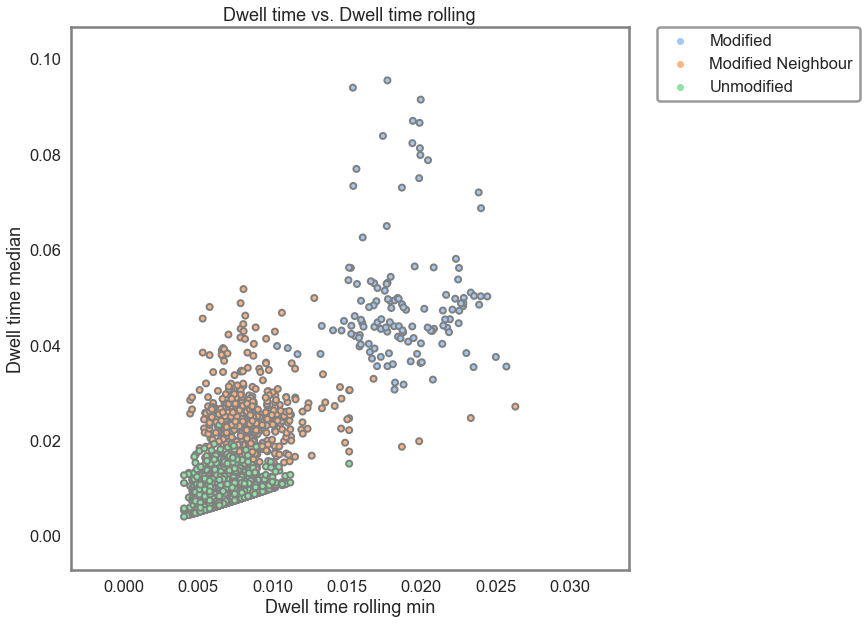

In [358]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(data=df_combined, x="dwell_time_rolling_min", y="dwell_time_median", hue="modified", 
                edgecolor="grey", linewidth = 2)
h,l = ax.get_legend_handles_labels()
legend = plt.legend(h[1:],l[1:],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True)
frame = legend.get_frame()
frame.set_linewidth(2.5)
yl = ax.get_ylabel()
yl = " ".join(yl.split("_")).capitalize()
ax.set_ylabel(yl)
xl = ax.get_xlabel()
xl = " ".join(xl.split("_")).capitalize()
ax.set_xlabel(xl)
plt.title("Dwell time vs. Dwell time rolling")
plt.savefig("figures/scatter_median_vs_rolling.png",dpi=300,bbox_inches="tight" );

# dwell time according to mod status

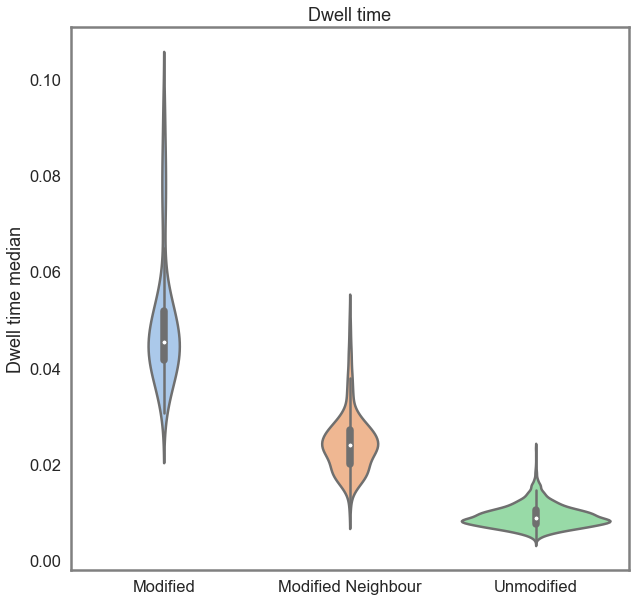

In [357]:
plt.figure(figsize=(10,10))
ax = sns.violinplot(data=df_combined, y="dwell_time_median", x="modified")
yl = ax.get_ylabel()
yl = " ".join(yl.split("_")).capitalize()
ax.set_ylabel(yl)
plt.xlabel("")
plt.title("Dwell time")
plt.savefig("figures/dwell_time_violin.png",dpi=300,bbox_inches="tight" );

In [356]:
# interactive plot for numeric features to see if base identity is correlated to values

@interact(base = ["base_1","base_2","base_3","base_4","base_5"], 
          y_axis = list(df_combined.columns[df_combined.dtypes ==  "float"]))
def test_plot(base, y_axis):
    plt.figure(figsize=(12,8))
    ax = sns.boxplot(data = df_combined, y = y_axis,x="modified", hue=base, hue_order=["A","G","C","T"],
               linewidth = 2.5)
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True)
    frame = legend.get_frame()
    frame.set_linewidth(2.5)
    ax.set_xlabel("")
    yl = ax.get_ylabel()
    yl = " ".join(yl.split("_")).capitalize()
    plt.title(" ".join(yl.split("_")).capitalize() + " and " + " ".join(str(base).split("_")).capitalize() + " Identity")
    ax.set_ylabel(yl);

interactive(children=(Dropdown(description='base', options=('base_1', 'base_2', 'base_3', 'base_4', 'base_5'),…

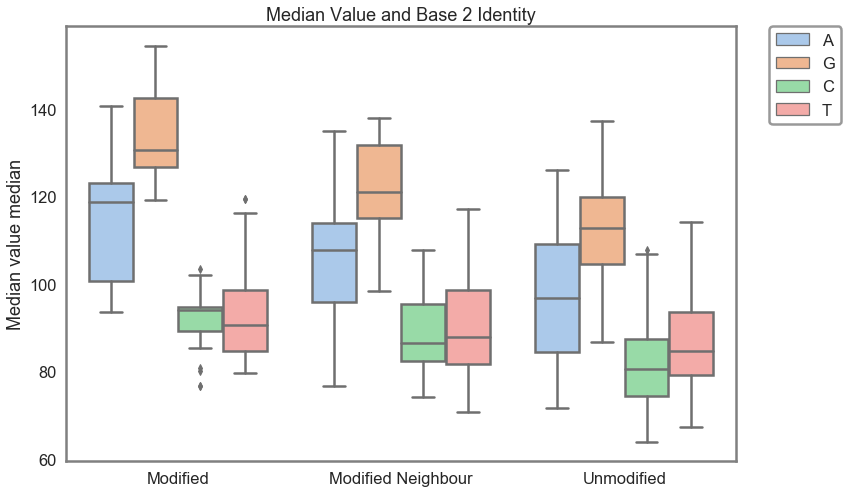

In [353]:

plt.figure(figsize=(12,8))
ax = sns.boxplot(data = df_combined, y = "median_value_median",x="modified", hue="base_2", hue_order=["A","G","C","T"],
           linewidth = 2.5)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True)
frame = legend.get_frame()
frame.set_linewidth(2.5)
ax.set_xlabel("")
yl = ax.get_ylabel()
yl = " ".join(yl.split("_")).capitalize()
ax.set_ylabel(yl)
plt.title("Median Value and Base 2 Identity")
plt.savefig("figures/box_base_2_median_value.png",dpi=300,bbox_inches="tight" );

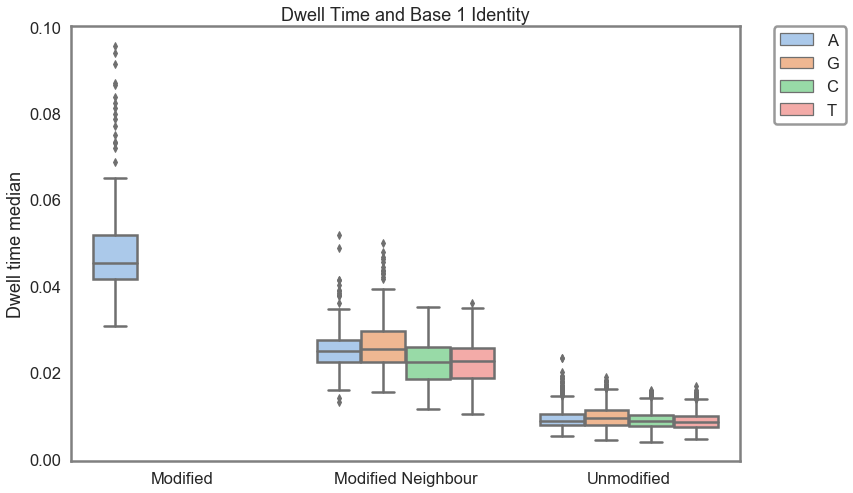

In [352]:

plt.figure(figsize=(12,8))
ax = sns.boxplot(data = df_combined, y = "dwell_time_median",x="modified", hue="base_1", hue_order=["A","G","C","T"],
           linewidth = 2.5)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True)
frame = legend.get_frame()
frame.set_linewidth(2.5)
ax.set_xlabel("")
yl = ax.get_ylabel()
yl = " ".join(yl.split("_")).capitalize()
ax.set_ylabel(yl)
plt.title("Dwell Time and Base 1 Identity")
plt.savefig("figures/box_base_1_dwell_time.png",dpi=300,bbox_inches="tight" );

# yeast data

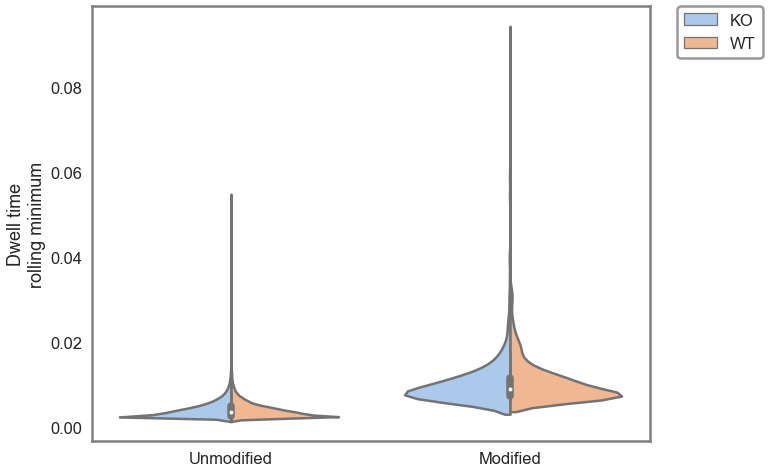

In [329]:
plt.figure(figsize=(10,8))
ax = sns.violinplot(data=df_yeast_combined_predicted, x="predicted_status", y="dwell_time_rolling_min", hue="file_type", 
               split=True, edgecolor = "grey")
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True)
frame = legend.get_frame()
frame.set_linewidth(2.5)
ax.set_xlabel("")
ax.set_xticklabels(["Unmodified","Modified"])
ax.set_ylabel("Dwell time\nrolling minimum");

# dna features

In [15]:
import imageio

In [12]:
df_dnaviewer = df_combined[["ref_number","file_name","base_3","dwell_time_median","dwell_time_rolling_min",
                            "dwell_time_diff_to_median","modified_status"]]

In [13]:
def getIndexes(dfObj, value):
    ''' Get index positions of value in dataframe i.e. dfObj.'''
    listOfPos = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    # Get list of columns that contains the value
    seriesObj = result.any()
    if seriesObj.any():
        columnNames = list(seriesObj[seriesObj == True].index)
        # Iterate over list of columns and fetch the rows indexes where value exists
        for col in columnNames:
            rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row))
        # Return a list of tuples indicating the positions of value in the dataframe
    else:
        listOfPos = False
    return listOfPos

In [338]:
def sequencing_plot(i,show = False):
    font =  {'size': 24, 
             'weight':'bold'}
    
    start_i = i
    stop_i =i+15
    
    start,stop = 0,15
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(
        4, 1,  figsize=(12, 10), sharex=True, gridspec_kw={"height_ratios": [1,1,1,1]}
    )

    
    df_temp = df_dnaviewer[(df_dnaviewer["file_name"]=="modified_rep_1.tsv") &
                (df_dnaviewer["ref_number"]=="ref_0000")][start_i:stop_i].reset_index()
    sequence = "".join(df_temp.base_3.values)

    modified_positions = getIndexes(df_temp[["base_3","modified_status"]], 1.0)
   
    if modified_positions:
        for elm in modified_positions:

            ax1.axvspan(elm-0.5, elm+0.5, color='red', alpha=0.2,zorder=0)
            ax2.axvspan(elm-0.5, elm+0.5, color='red', alpha=0.2,zorder=1)
            ax3.axvspan(elm-0.5, elm+0.5, color='red', alpha=0.2,zorder=1)
            ax4.axvspan(elm-0.5, elm+0.5, color='red', alpha=0.2,zorder=1)
            
    
            
    box1 = patches.Rectangle (xy=(4.5,1), width = 5, height = 2, edgecolor="grey",
                             linewidth=2.5, facecolor = "#FFB482")
    box2 = patches.FancyBboxPatch (xy=(6.5,5), width = 1, height = 2, edgecolor="grey",
                             linewidth=2.5, facecolor = "#A1C9F4", boxstyle = "Round4")
    
    ax1.add_patch(box1)
    ax1.add_patch(box2)
    ax1.set_ylim(0,10)
    ax1.text(7,2,s="reading frame", ha="center", va="center")
    ax1.text(7,6,s="center", ha="center", va="center")
    ax1.text(-0.3,2, va="center", ha="center", s="3'")
    ax1.text(14.3,2, va="center", ha="center", s="5'")
    ax1.plot(np.arange(start,stop),np.full(stop,2), color="grey", zorder=0)
    ax1.plot([4.5,6.5],[3,5],color = "grey", zorder=0)
    ax1.plot([7.5,9.5],[5,3], color="grey", zorder=0)
    ax1.axis("off")
    ax1.set_yticklabels([""])
    
    bl = "#A1C9F4"
    gr = "#8DE5A1"
    og = "#FFB482"
    
    bar_colors = [gr,gr,gr,gr,gr,og,og,bl,og,og,gr,gr,gr,gr,gr,]
    
    ax2.bar(x=range(0,stop-start),height=df_temp.dwell_time_median, linewidth=2.5,
            edgecolor="grey",zorder=2, color = bar_colors)
    ax2.set_ylabel("Dwell Time\nMedian")
    ax2.set_ylim(0,0.1)
    ax2.set_yticklabels([""])
    
    
    ax3.bar(x=range(0,stop-start),height=df_temp.dwell_time_rolling_min, linewidth=2.5,
            edgecolor="grey",zorder=2, color = bar_colors)
    ax3.set_ylabel("Dwell Time\nRolling Minimum")
    ax3.set_ylim(0,0.03)
    ax3.set_yticklabels([""])
    
    ax4.bar(x=range(0,stop-start),height=df_temp.dwell_time_diff_to_median, linewidth=2.5, 
            edgecolor="grey",zorder=2, color = bar_colors)
    ax4.set_ylabel("Dwell Time\nDiff to Median")
    ax4.set_ylim(0,0.1)
    ax4.set_yticklabels([""])
    ax4.set_xticks(np.arange(start,stop))
    ax4.set_xticklabels(list(sequence), fontdict=font )
    ax4.set_xlim(-0.5,14.5)

    #plt.figure(edgecolor = "grey")
    plt.suptitle("DNA-Nanoporesequencing readout")
    #plt.tight_layout()
    plt.subplots_adjust(top=0.95,hspace = 0)
    
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    if show:
        plt.show()
    plt.close();

    return image
    

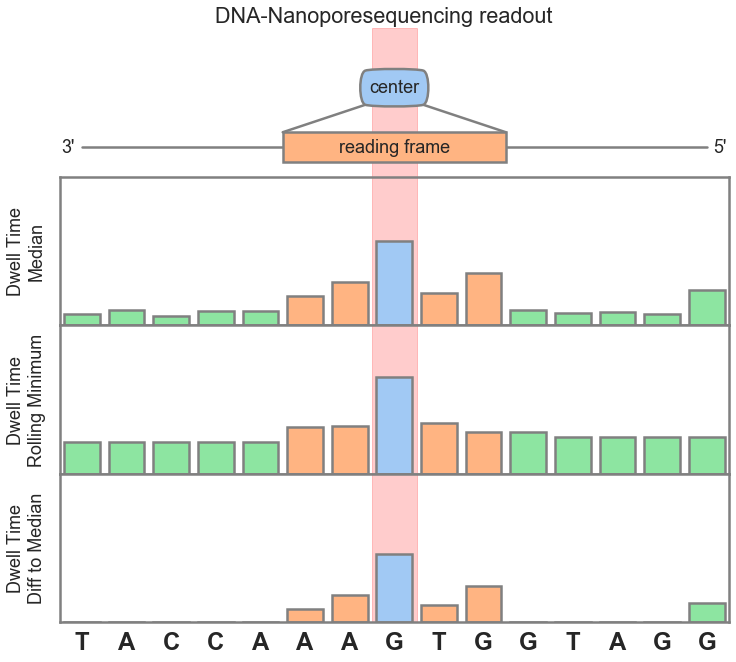

In [339]:
a = sequencing_plot(12, True)

In [206]:
kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('gif/sequencing_plot.gif', [sequencing_plot(i) for i in range(181)], fps=2, subrectangles=True)